## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze toy examples, recognize faces and segment skin lesion images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). All questions are mandatory for IMP only some are mandatory for IMH.

You have two weeks (26/11) to update the three jupyter-notebooks to the Moodle under the section *Reports-TP* **AS A SINGLE ZIP FILE**. You can answer in French or English. The deadline is 23:59 of the 26th of November. I remind you that the report is mandatory and evaluated. 

**All reports uploaded after the deadline will not be evaluated, namely grade equal to 0**

In this jupyter notebook, you can play with the toy examples shown during the lecture. 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')
import random
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group

The next three functions are used to create the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X=None,U=None,Y=None,const=1,title=''):
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

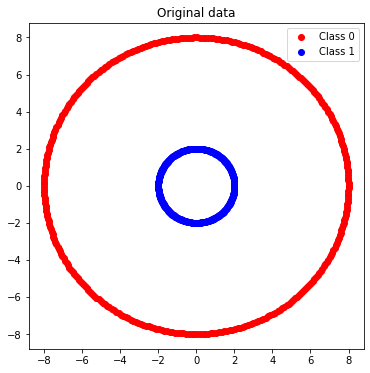

In [3]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

It's time to use the methods seen this morning. 

As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 

Let's start with PCA. 

**Question:**
1. (IMP + IMH) Use PCA with the different 4 scenarios and comment the results. When does PCA work well ?
Answer: The PCA worked best when we could lineary discriminant between the two class such as in scenario number 1 and 2

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


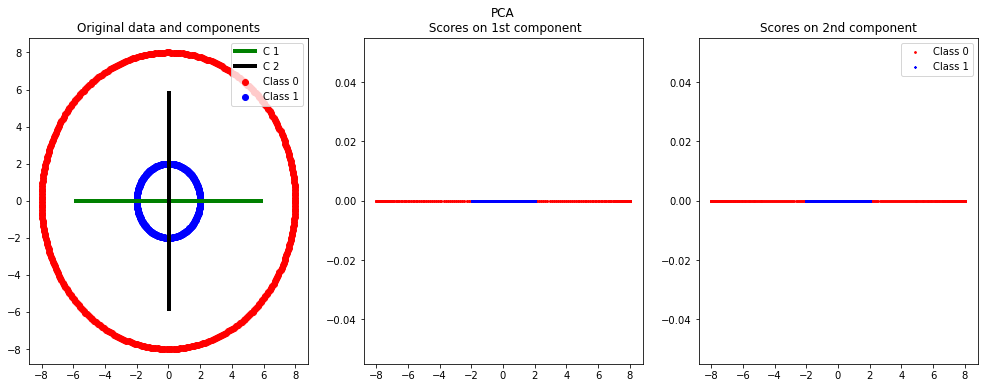

In [4]:
X=np.concatenate((X0,X1),axis=0)

## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')

**Question:**
1. (IMP) Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

**Answer:**
DONE!


In [5]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    Xc=X-np.mean(X) # centering
    D2, Uh = LA.svd(Xc)[1:3] # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    #De, Ue = LA.eig(np.matmul(Xc.T,Xc)/(N-1))    
    Y=np.dot(Xc,Uh) # computation of the scores, use np.dot()
    D=D2**2/(N-1) # computation of the eigenvalues
    tot=np.sum(D)
    var_explained = D*100/tot # computation of explained variance
    return Y,U,D,var_explained

**Question:**
1. (IMP ) Test your own implementation and check whether the results are the same of the scikit-learn implementation

**Answer:**
DONE!

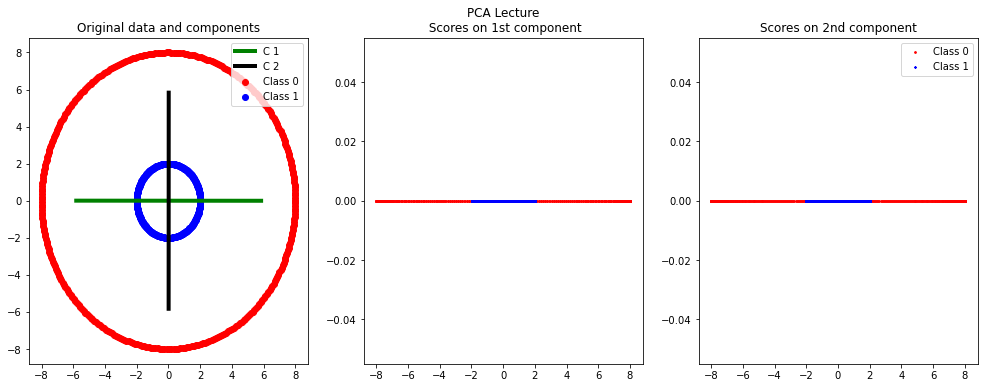

In [6]:
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

Let's use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. (IMP + IMH) Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

**Answer:**
The Kernel-PCA supposed to work better on non-linear data since it uses a function to project dataset into a higher-dimensional space, where it is linearly separable.

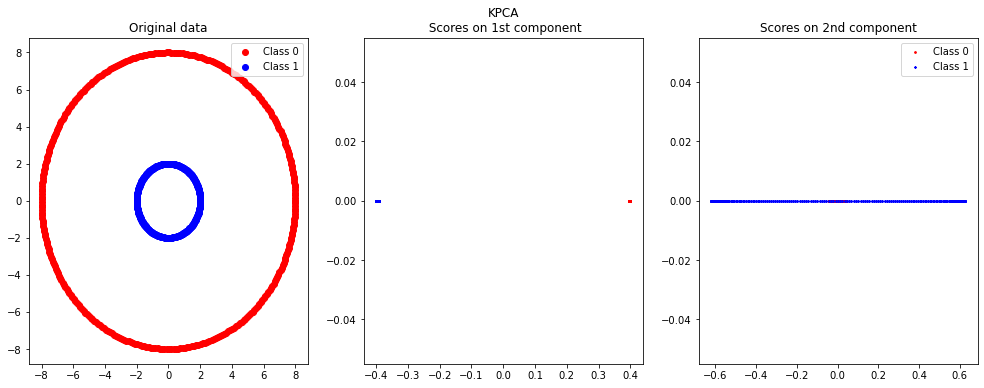

In [7]:
# Kernel-PCA
gamma=0.1
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X=X,Y=YKpca,const=1,title='KPCA')

**Question:**
1. (IMP) Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

**Answer:**
DONE!

In [8]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0) 
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;    
      K=np.exp(-Norm/(2*gamma**2))
      return K
       
    N=X.shape[0]

    K=kernel_matrix(X,gamma)
    
    oneN=np.ones((N,N))/N;
    Kc=scale(K,with_mean=True,with_std=False)# center kernel matrix

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )          
           
    Y=np.dot(Kc,An) # computation of the scores, use np.dot()  
    
    return Y,An,D,var_explained

**Question:**
1. (IMP) Test your own implementation

**Answer:**
DONE!

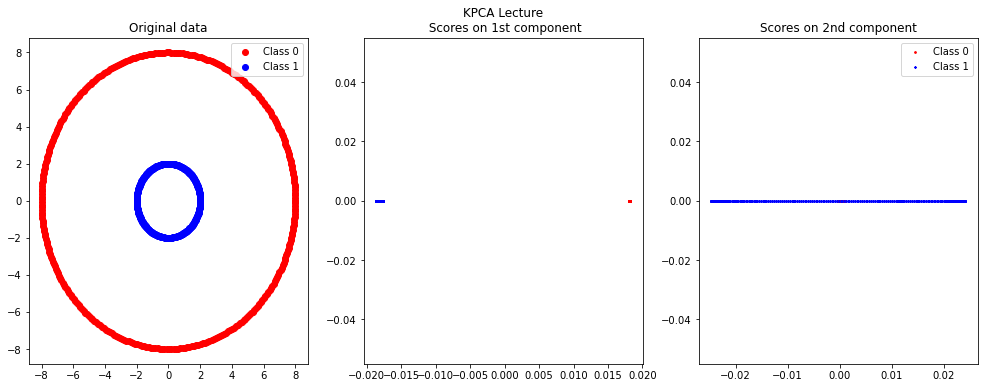

In [9]:
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma=2)
plotResults(X=X,Y=YKpcaLec,const=1,title='KPCA Lecture')

Now, test ICA.

**Question:**
1. (IMP + IMH) Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

**Answer:**
scenario 3 was significantly better with the ICA since it managed to find the independent components of class 1 (blue). Unlike PCA the ICA does not try to maximize the variance of the data points but to try to find the independence of the components.

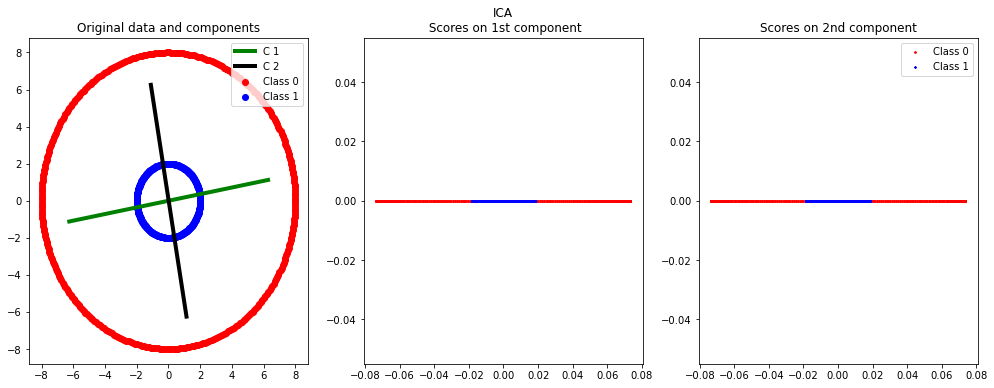

In [10]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X=X,U=Wica,Y=Yica,const=0.01,title='ICA')

**Question:**
1. (IMP) Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

**Answer:**
DONE!

In [11]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    random.seed(42)
    # First derivative of G   
    def g(t):
        res = t * np.exp(-(t**2)/2)
        return res
    
    # Second derivative of G  
    def gp(t):
        res = (1 - t**2) * np.exp(-(t**2)/2)
        return res
    
    # Size of X
    d,N=X.shape 
        
    # Compute sample mean   
    mu = X.mean(axis=1, keepdims=True)
    
    # Center data    
    #Xc=X-np.mean(X)
    Xc=X-np.mean(X)
    
    # Compute covariance matrix    
    C=np.cov(Xc)
    
    # Whiten data
    Xcw=np.dot(LA.inv(LA.sqrtm(C)),Xc)
    
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        
        Wp = np.dot(g(np.dot(W,Xcw)),Xcw.T) - np.dot(np.diagflat(np.dot(gp(np.dot(W,Xcw)),np.ones((N,1)))),W)  
        W = np.dot(LA.inv(LA.sqrtm(np.dot(Wp,Wp.T))),Wp) # W*W'=I
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = np.dot(W,Xcw)
            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W

**Question:**
1. (IMP) Test your own implementation

**Answer:**
DONE!

Iteration ICA number  1  out of  3000 , delta =  1.4733763703533853e-05
Convergence achieved ( delta =  9.923919016441296e-06 ) in  58  iterations


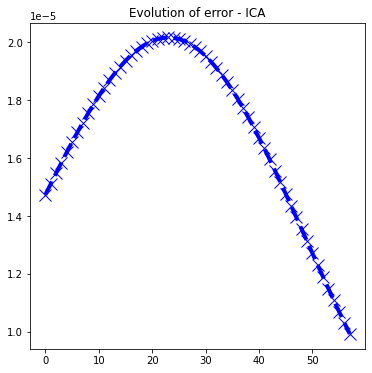

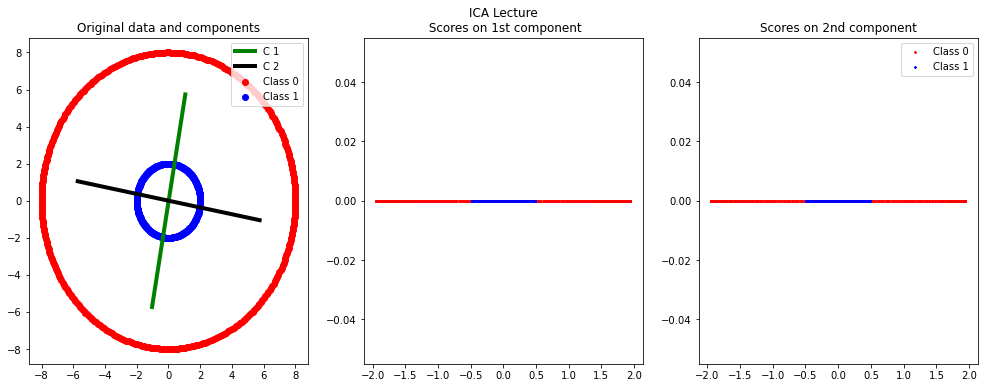

In [12]:
SicaLec,WicaLec = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X=X, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


With a different perspective, we could also use K-means. As before, we will use it on X and we will check whether it can well separate the two classes. 


**Question:**
1. (IMP + IMH) Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

**Answer:**
well, it is not easy to always define the correct number of clusters. for example, when the data is linearly separable 2 clusters should do the trick but when it is not we should increase the number of clusters and afterward define that if we know that class 0 is correct and change the rest to class 1. for example in scenario 4, 5 clusters almost always identify class 1 (blue) correctly and the other clusters are just class 0(red).


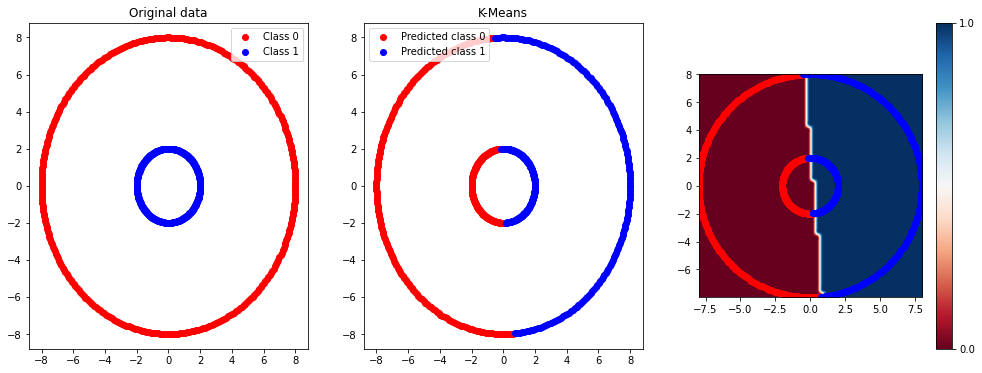

In [13]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()